# Introduction


File IPYNB ini digunakan untuk membuat model klasifikasi sampah yang dibagi menjadi 6 class yaitu sampah kertas, sampah gelas kaca / beling, sampah plastik, sampah metal, sampah kertas karton , dan sampah lainnya.Tujuan pembuatan model ini dipergunakan untuk membagi dan membedakan jenis jenis sampah yang dapat digunakan pada alat penyortiran sampah ditempat penampungannya atau tempat daur ulangnya

# Library

In [89]:
pip install wandb


In [9]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

berikut library yang digunakan dalam proses pembuatan model mulai dari data preparation, exploratory data dan data preprocessingnya

# Data Loading

In [10]:
!unzip ./dataset-resized.zip

Archive:  ./dataset-resized.zip
replace dataset-resized/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset-resized/.DS_Store  
  inflating: __MACOSX/dataset-resized/._.DS_Store  
  inflating: dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset-resized/cardboard/cardboard106.jpg  
  inflating: dataset-resized/cardboard/cardboard107.jpg  
  inflating: dataset-resized/cardboard/cardboard108.jpg  
  inflating: dataset-resized/cardboard/cardboard109.jpg  
  inflating: dataset-resized/cardboard/cardboard11.jpg  
  inflating: dataset-resized/cardboard/cardboard11

In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path dataset asli
original_dataset_dir = "/content/dataset-resized"
base_dir = "/content/dataset-split"  # Folder untuk menyimpan data yang di-split
os.makedirs(base_dir, exist_ok=True)

# Subfolder untuk train+val dan test
train_val_dir = os.path.join(base_dir, "train_val")  # Gabungan train dan val
test_dir = os.path.join(base_dir, "test")

# Buat subfolder untuk train+val dan test
for folder in [train_val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Proses splitting
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_path):  # Hanya proses folder
        # Ambil semua file di kelas ini
        file_paths = [os.path.join(class_path, fname) for fname in os.listdir(class_path)]

        # Split train+val dan test
        train_val_files, test_files = train_test_split(file_paths, test_size=0.2, random_state=42)

        # Buat subfolder per kelas
        for split, split_files in zip(
            [train_val_dir, test_dir],
            [train_val_files, test_files]
        ):
            split_class_dir = os.path.join(split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in split_files:
                shutil.copy(file, split_class_dir)  # Salin file ke folder split

print("Dataset berhasil dibagi!")

Dataset berhasil dibagi!


membagi folder menjadi 2 folder train_val dan folder test

In [12]:
# Define path

main_path = '/content/dataset-split'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')

# Exploratory Data Analysis

In [13]:

IMG_SIZE = 400
path = '/content/dataset-split'

datagen = tf.keras.preprocessing.image.ImageDataGenerator()
data = datagen.flow_from_directory(path, (IMG_SIZE, IMG_SIZE), batch_size=32, class_mode='categorical', shuffle=True) # `class_mode=categorical` for multiclass

Found 2527 images belonging to 2 classes.


terdapat 2527 gambar yang dibagi menjadi 6 class

In [14]:
# Show images in pixel form

print('Images : ', data[0][0])
print('Shape  : ', data[0][0].shape)

Images :  [[[[242. 237. 234.]
   [242. 237. 234.]
   [241. 236. 233.]
   ...
   [208. 203. 199.]
   [207. 202. 198.]
   [207. 202. 198.]]

  [[242. 237. 234.]
   [242. 237. 234.]
   [241. 236. 233.]
   ...
   [208. 203. 199.]
   [207. 202. 198.]
   [207. 202. 198.]]

  [[242. 237. 234.]
   [241. 236. 233.]
   [241. 236. 233.]
   ...
   [208. 203. 199.]
   [207. 202. 198.]
   [207. 202. 198.]]

  ...

  [[238. 234. 233.]
   [238. 234. 233.]
   [237. 233. 232.]
   ...
   [197. 192. 189.]
   [197. 192. 189.]
   [197. 192. 189.]]

  [[238. 234. 233.]
   [238. 234. 233.]
   [237. 233. 232.]
   ...
   [198. 193. 190.]
   [197. 192. 189.]
   [197. 192. 189.]]

  [[238. 234. 233.]
   [238. 234. 233.]
   [237. 233. 232.]
   ...
   [198. 193. 190.]
   [197. 192. 189.]
   [197. 192. 189.]]]


 [[[223. 225. 238.]
   [223. 225. 238.]
   [223. 225. 238.]
   ...
   [212. 211. 225.]
   [212. 211. 225.]
   [212. 211. 225.]]

  [[223. 225. 238.]
   [223. 225. 238.]
   [223. 225. 238.]
   ...
   [212. 21

bentuk ukuran gambar menjadi Shape  :  (32, 400, 400, 3)

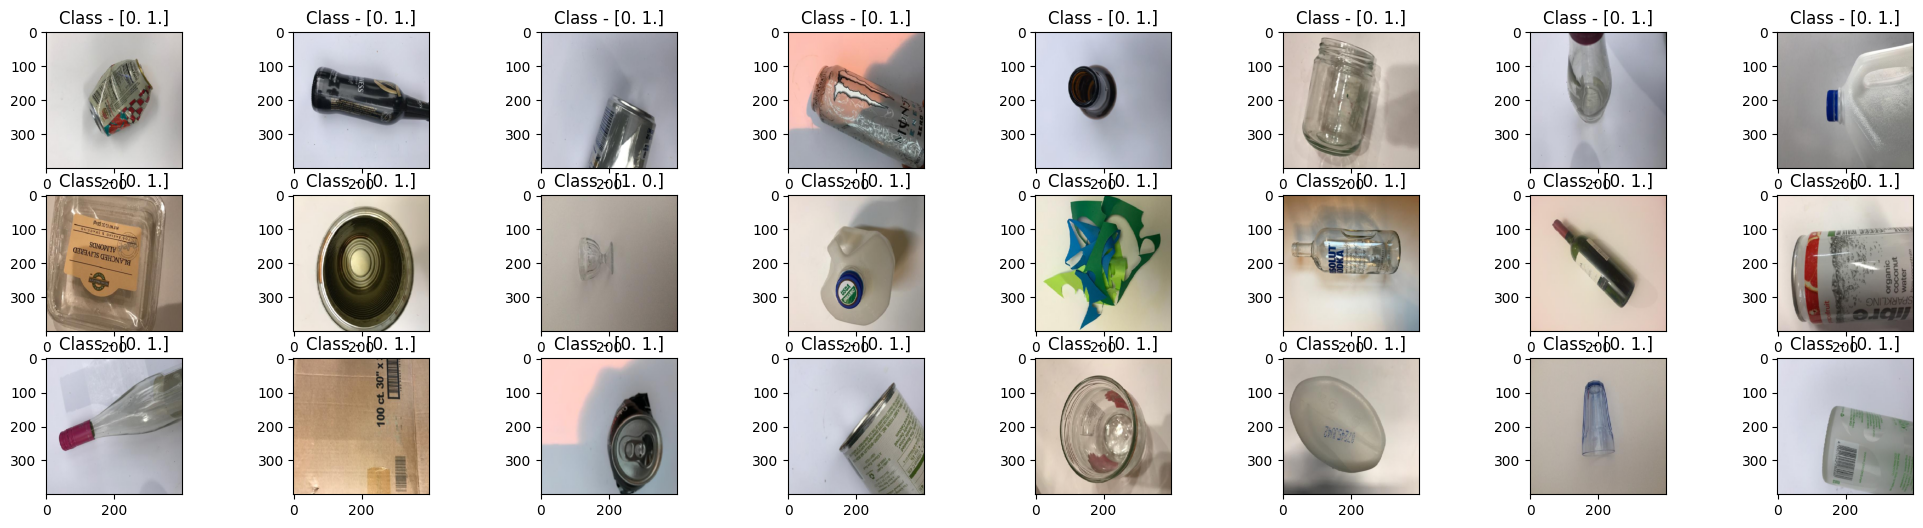

In [15]:
# Show each of image from both categories

fig, ax = plt.subplots(nrows=3, ncols=8, figsize=(25,6))
n = 0

for i in range(3):
  for j in range(8):
    img = data[0][0][n].astype('uint8')
    ax[i][j].imshow(img)
    ax[i][j].set_title('Class - ' + str(data[0][1][n]))
    n += 1

Berikut contoh gambar yang diambil dari dataset beserta class classnya

Rata-rata per channel (R, G, B): 183.17830208333334
Standar deviasi per channel (R, G, B): 39.17236549895533
Nilai pixel minimum: 36
Nilai pixel maksimum: 239


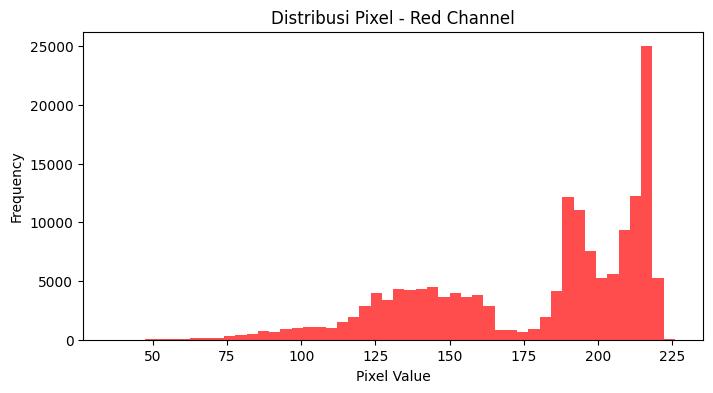

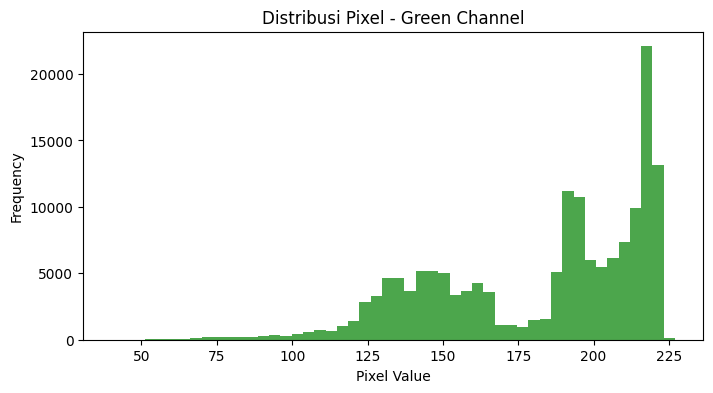

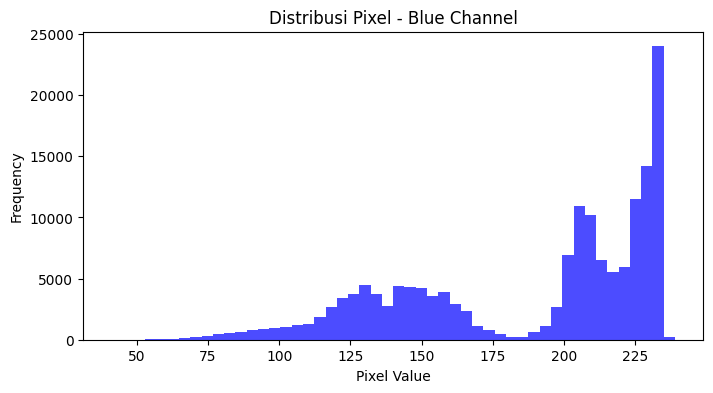

In [19]:
# Menghitung statistik pixel
mean_per_channel = img.mean(axis=(0, 1, 2))  # Rata-rata per channel (R, G, B)
std_per_channel = img.std(axis=(0, 1, 2))    # Standar deviasi per channel (R, G, B)
min_pixel_value = img.min()                  # Nilai pixel minimum
max_pixel_value = img.max()                  # Nilai pixel maksimum

print("Rata-rata per channel (R, G, B):", mean_per_channel)
print("Standar deviasi per channel (R, G, B):", std_per_channel)
print("Nilai pixel minimum:", min_pixel_value)
print("Nilai pixel maksimum:", max_pixel_value)

# Visualisasi Distribusi Pixel per Channel
channels = ['Red', 'Green', 'Blue']
for i in range(3):  # Loop untuk setiap channel
    plt.figure(figsize=(8, 4))
    plt.hist(img[..., i].ravel(), bins=50, color=channels[i].lower(), alpha=0.7)
    plt.title(f'Distribusi Pixel - {channels[i]} Channel')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

adapun nilai minimum RGB ada di angka 39.

dan nilai maximum RGB ada di angka 239

dengan rata rata per channel (R,G,B) di 183.178

dan standar deviasi per channel (R, G, B): 39.17

# Feature Engineering

In [20]:
# Define hyperparameters

img_height= 250
img_width= 250
batch_size= 64

height gambar dan width gambar menjadi 250x250 dengan batch size 64

In [21]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_val_dir,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_val_dir,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 1213 images belonging to 6 classes.
Found 806 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


pembagian dataset 1213 dataset dibagi menjadi dataset train

806 dataset menjadi dataset  validation

dan 508 dataset menjadi dataset test

In [22]:
# Show labels

train_set.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

pembagian klasifikasi sampah menjadi 6 bagian

# ANN Training

### Model Definition

In [24]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

pembuatan model dengan penambahan layer layer dan penambahan flatten dan dropout

In [25]:
# Create Sequential API model

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      55,116,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,212,614 (210.62 MB)

 Trainable params: 55,212,614 (210.62 MB)

 Non-trainable params: 0 (0.00 B)

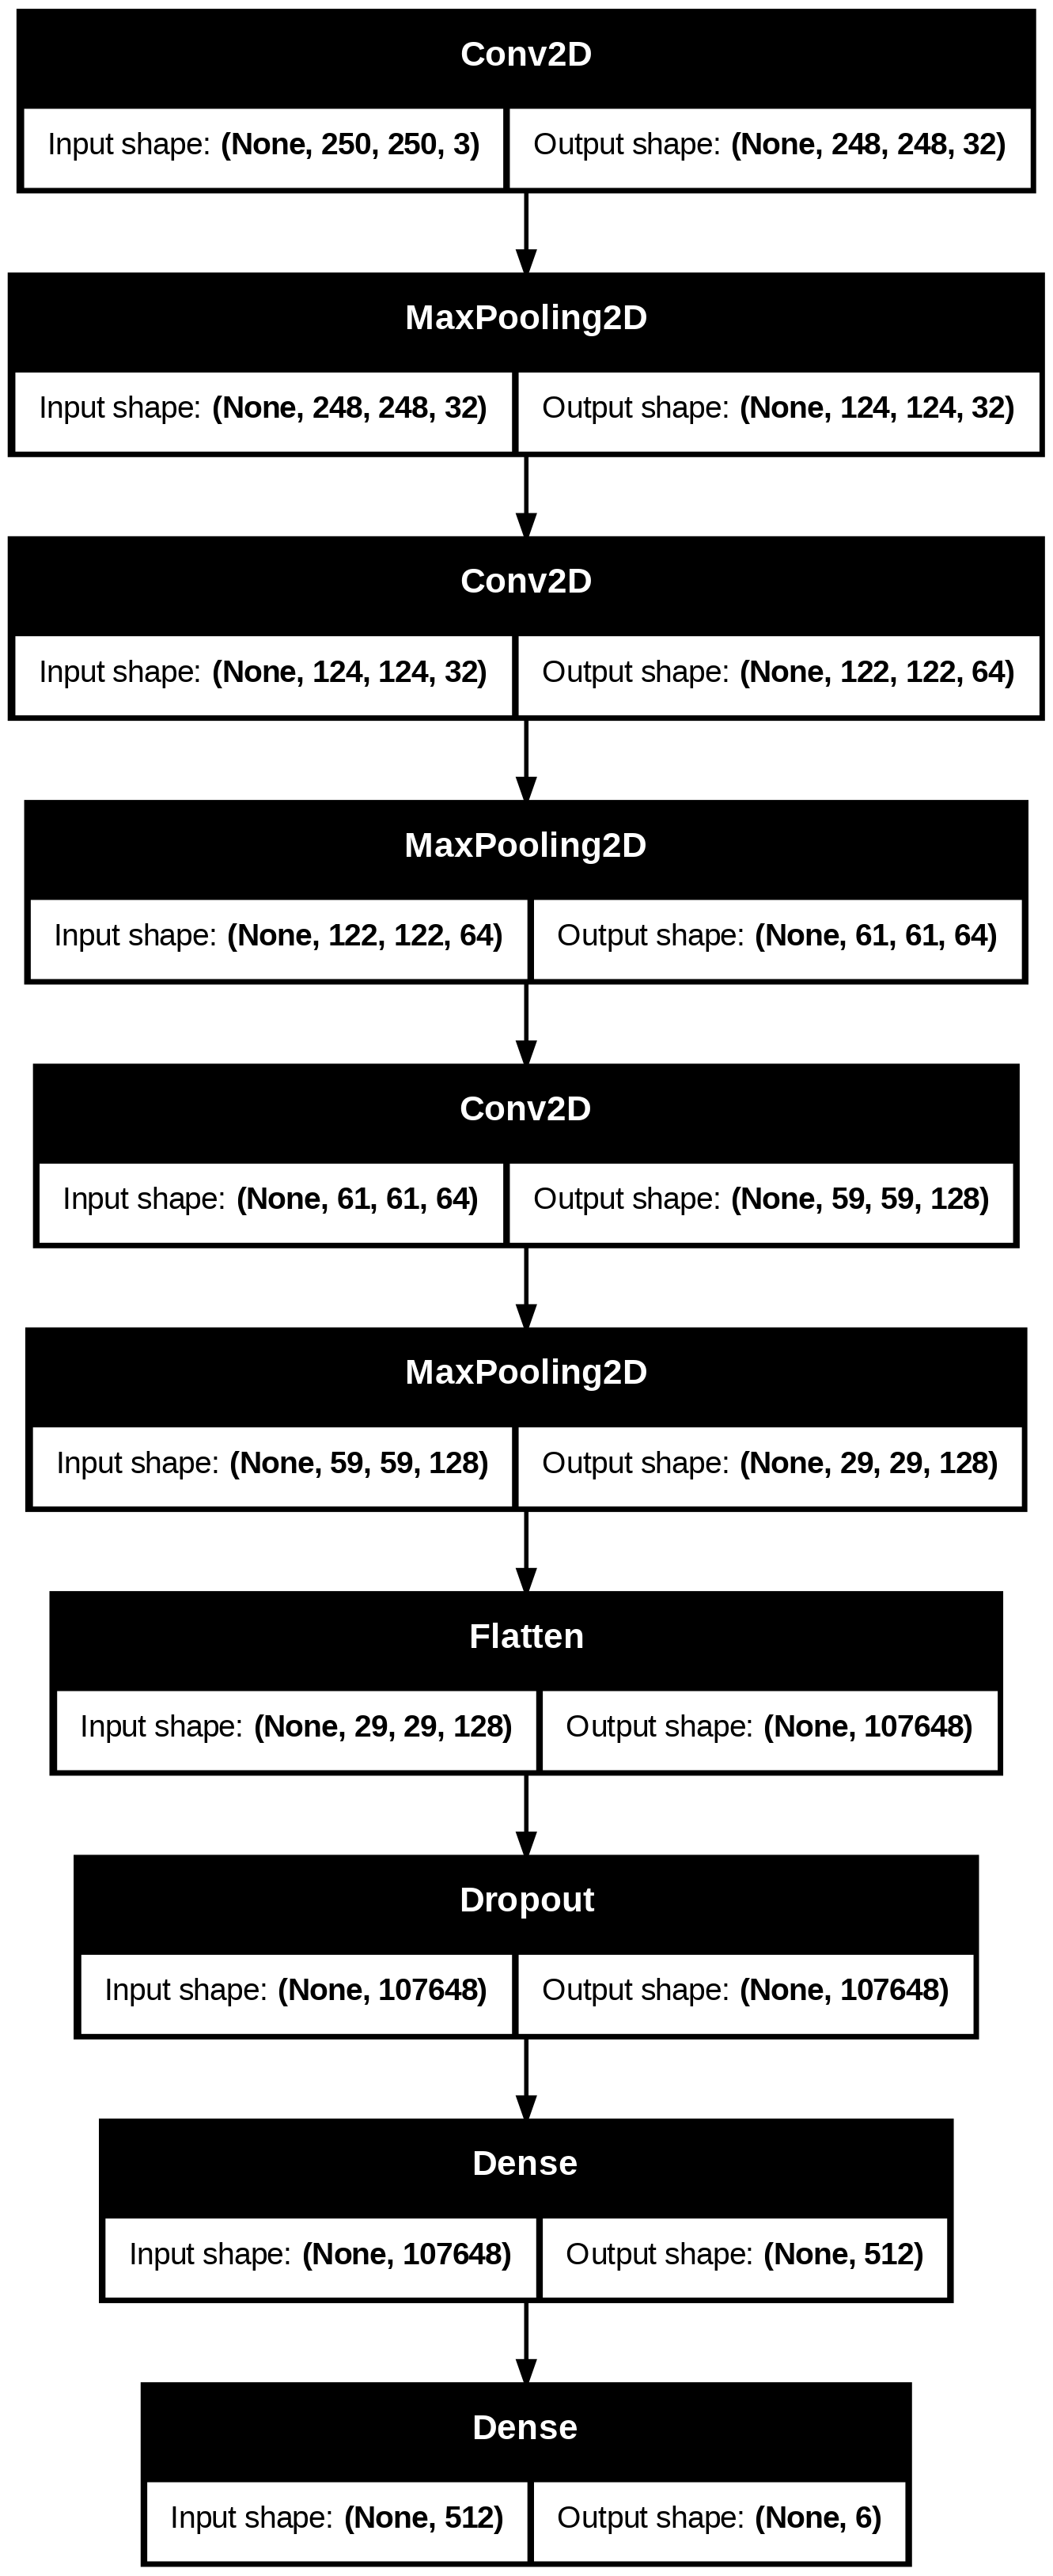

In [26]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

### Model Training

In [30]:
# Train the model

%%time
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(train_set, epochs=20, validation_data=val_set,callbacks=[early_stopping], batch_size=batch_size)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.4570 - loss: 1.6160 - val_accuracy: 0.3002 - val_loss: 1.7333
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.4395 - loss: 1.4134 - val_accuracy: 0.3238 - val_loss: 1.8803
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step - accuracy: 0.6342 - loss: 1.0201 - val_accuracy: 0.3412 - val_loss: 2.1547
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.7252 - loss: 0.7471 - val_accuracy: 0.3400 - val_loss: 2.2866
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.7952 - loss: 0.7496 - val_accuracy: 0.3052 - val_loss: 2.5987
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - accuracy: 0.8439 - loss: 0.4925 - val_accuracy: 0.3400 - val_loss: 2.8403
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.8607 - loss: 0.3746 - val_accuracy: 0.3486 - val_loss: 2.7460
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.9111 - loss: 0.3158 - val_accuracy: 

### Model Evaluation

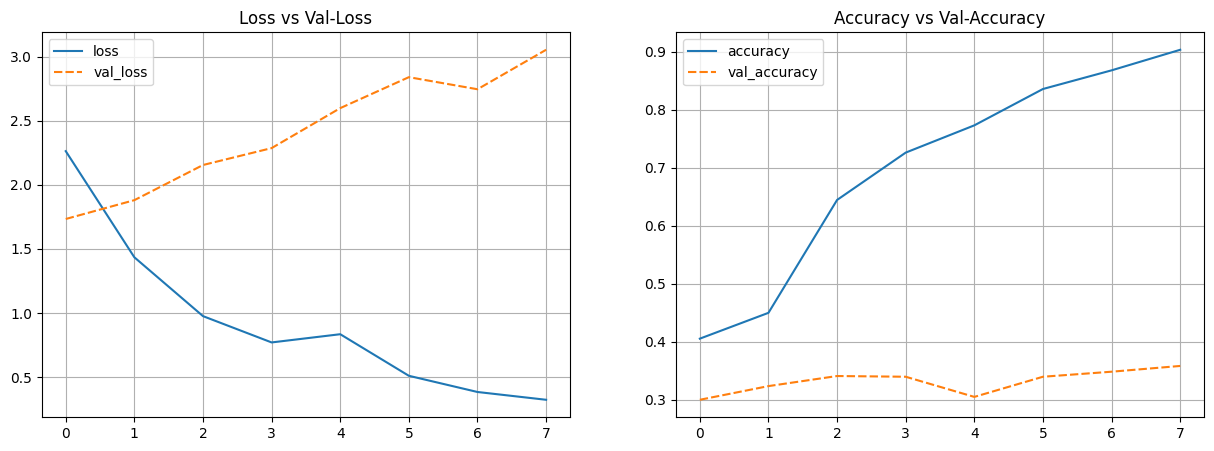

In [31]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

setelah dilakukan training hasil dari training setelah menggunakan early stop berhenti pada epoch ke 8 dengan hasil accuracy: 0.9111 - loss: 0.3158 - val_accuracy: 0.3586 - val_loss: 3.0541


In [32]:
# Get the probability predictions
y_pred_prob = model.predict(test_set)

# Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

# Assuming test_set.classes contains the true labels
print(classification_report(test_set.classes, y_pred_class, target_names=test_set.class_indices.keys()))


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 549ms/step
              precision    recall  f1-score   support

   cardboard       1.00      0.01      0.02        81
       glass       0.26      0.31      0.28       101
       metal       0.22      0.46      0.30        82
       paper       0.49      0.44      0.46       119
     plastic       0.26      0.28      0.27        97
       trash       0.14      0.04      0.06        28

    accuracy                           0.30       508
   macro avg       0.40      0.26      0.23       508
weighted avg       0.42      0.30      0.27       508



model masih terpantau tidak bagus dengan akurasi hanya 30%

Hal ini menunjukan bahwa model masih perlu dilakukan improvement untuk mendapatkan model terbaik

# ANN Improvement

## ANN Improvement with Augmentation

In [37]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [38]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.05,
                                                                    width_shift_range=0.05,
                                                                    height_shift_range=0.05,
                                                                    shear_range=0.05,
                                                                    horizontal_flip=True,
                                                                    validation_split=0.4)

train_set_aug = train_datagen_aug.flow_from_directory(train_val_dir,
                                                      target_size=(img_height,img_width),
                                                      class_mode='sparse',
                                                      subset='training',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(train_val_dir,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_dir,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

Found 1213 images belonging to 6 classes.
Found 806 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [39]:
# Create Sequential API model

model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dense(6, activation='softmax'))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      55,116,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,212,614 (210.62 MB)

 Trainable params: 55,212,614 (210.62 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [40]:
# Train the model

%%time
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_aug = model_aug.fit(train_set_aug, epochs=20, validation_data=val_set_aug,callbacks=[early_stopping], batch_size=batch_size)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2039 - loss: 1065.5732 - val_accuracy: 0.1117 - val_loss: 1.8067
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2949 - loss: 1.6476 - val_accuracy: 0.2779 - val_loss: 2.0958
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3480 - loss: 1.6484 - val_accuracy: 0.2730 - val_loss: 1.7022
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3781 - loss: 1.5024 - val_accuracy: 0.2593 - val_loss: 1.7933
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3313 - loss: 1.6450 - val_accuracy: 0.3251 - val_loss: 1.6285
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4083 - loss: 1.4544 - val_accuracy: 0.3524 - val_loss: 1.6622
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4488 - loss: 1.3994 - val_accuracy: 0.3834 - val_loss: 1.7391
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4592 - loss: 1.3578 - val_accuracy: 0.3772 - val_lo

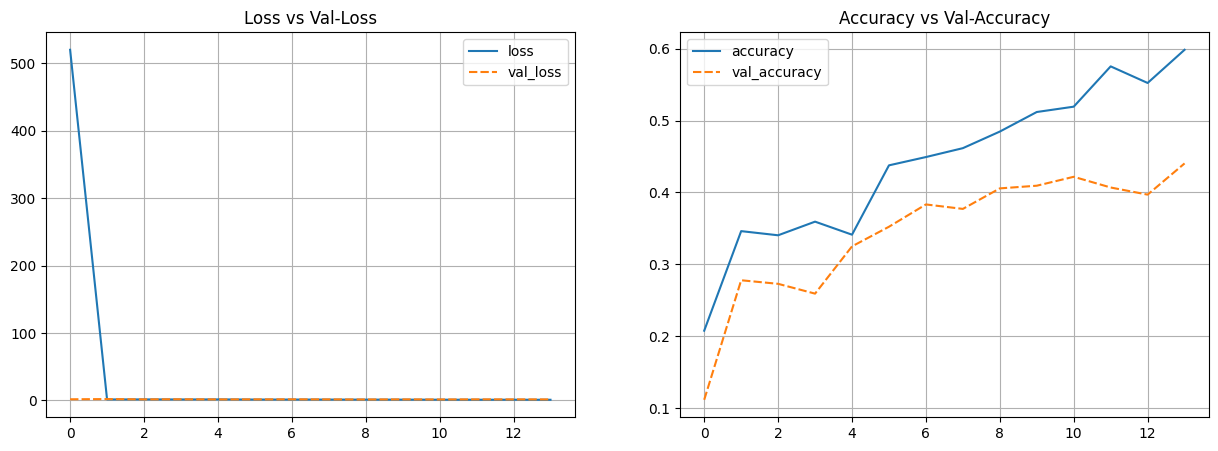

In [41]:
# Plot training results

history_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [42]:
# Get the probability predictions
y_pred_prob = model_aug.predict(test_set)

# Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

# Assuming test_set.classes contains the true labels
print(classification_report(test_set.classes, y_pred_class, target_names=test_set.class_indices.keys()))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step
              precision    recall  f1-score   support

   cardboard       0.77      0.68      0.72        81
       glass       0.44      0.21      0.28       101
       metal       0.32      0.45      0.38        82
       paper       0.43      0.45      0.44       119
     plastic       0.38      0.53      0.44        97
       trash       0.28      0.18      0.22        28

    accuracy                           0.44       508
   macro avg       0.44      0.41      0.41       508
weighted avg       0.45      0.44      0.43       508



setelah dilakukan improvement pada model menggunakan augmentation terjadi perbaikan pada nilai akurasi dengan menunjukan 44% dan nilai f1 score dengan 0.72 untuk class cardboard

## ANN Improvement With TransferLearning Using VGG16

### Model Definition

In [43]:
# Define hyperparameters

img_height= 224
img_width= 224
batch_size= 64

In [44]:

pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))
pretrained_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.05,
                                                                   width_shift_range=0.05,
                                                                   height_shift_range=0.05,
                                                                   shear_range=0.05,
                                                                   horizontal_flip=True,
                                                                   validation_split=0.4,
                                                                   preprocessing_function=preprocess_input)

train_set_tl = train_datagen_tl.flow_from_directory(train_val_dir,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

val_set_tl = train_datagen_tl.flow_from_directory(train_val_dir,
                                                  target_size=(img_height,img_width),
                                                  class_mode='sparse',
                                                  subset='validation',
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  seed=2)

test_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_set_tl = test_datagen_tl.flow_from_directory(test_dir,
                                                  target_size=(img_height,img_width),
                                                  class_mode='sparse',
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=2)

Found 1213 images belonging to 6 classes.
Found 806 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [46]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [47]:
# Create Sequential API model
model_tl = Sequential()
model_tl.add(pretrained_model)


input_shape = (None, img_height, img_width, 3)
model_tl.build(input_shape=input_shape)

model_tl.add(Flatten())
model_tl.add(Dropout(0.5))
model_tl.add(Dense(512, activation='relu'))
model_tl.add(BatchNormalization())
model_tl.add(Dense(6, activation='softmax'))

# Compile the model
model_tl.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model_tl.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,565,382 (105.15 MB)

 Trainable params: 12,849,670 (49.02 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

### Model Training

In [48]:
# Train the model

%%time

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_tl = model_tl.fit(train_set_tl, epochs=20, validation_data=val_set_tl,callbacks=[early_stopping], batch_size=batch_size)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.5763 - loss: 1.6086 - val_accuracy: 0.7047 - val_loss: 2.8658
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8839 - loss: 0.3784 - val_accuracy: 0.7320 - val_loss: 1.6666
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9335 - loss: 0.1948 - val_accuracy: 0.7333 - val_loss: 1.3095
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9681 - loss: 0.0954 - val_accuracy: 0.7506 - val_loss: 1.1567
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9706 - loss: 0.0889 - val_accuracy: 0.7667 - val_loss: 1.0826
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9808 - loss: 0.0731 - val_accuracy: 0.7593 - val_loss: 1.0758
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9793 - loss: 0.0641 - val_accuracy: 0.7730 - val_loss: 0.9580
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9825 - loss: 0.0426 - val_accuracy: 0.7767 - val_loss:

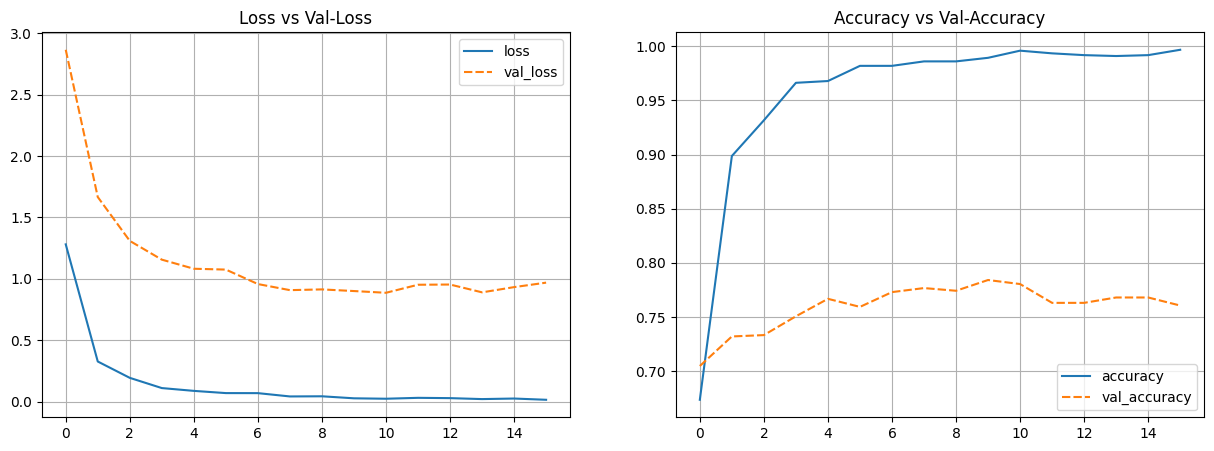

In [49]:
# Plot training results

history_tl_df = pd.DataFrame(history_tl.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

setelah dilakukan training pada trainset dan berhenti di epoch 16 hasil yang didapatkan

accuracy: 0.9979 - loss: 0.0142 - val_accuracy: 0.7605 - val_loss: 0.9694

In [50]:
# Check the performance of test-set

## Get the probability
y_pred_prob_tl = model_tl.predict(test_set_tl)

## Get class with maximum probability
y_pred_class_tl = np.argmax(y_pred_prob_tl, axis=-1)

## Display Classification Report
print(classification_report(test_set_tl.classes, y_pred_class_tl, target_names=np.array(list(train_set_tl.class_indices.keys()))))

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
              precision    recall  f1-score   support

   cardboard       1.00      0.81      0.90        81
       glass       0.81      0.72      0.76       101
       metal       0.82      0.88      0.85        82
       paper       0.83      0.95      0.89       119
     plastic       0.75      0.78      0.76        97
       trash       0.58      0.54      0.56        28

    accuracy                           0.82       508
   macro avg       0.80      0.78      0.79       508
weighted avg       0.82      0.82      0.82       508



setelah dilakukan pemodelan pada test set akurasi menunjukan angka 82% dengan recall tertinggi di angka 0.95 untuk kelas paper dan f1 score tertinggi diangka 0.90 untuk kelas cardboard

namun gap antara loss dan val loss yang cukup jauh dan accuracy dengan val accuracy yang cukup jauh menunjukan model cenderung overfit

## ANN Improvement With TransferLearning Using RestNet

### Model Definition

In [51]:
# Define hyperparameters

img_height= 224
img_width= 224
batch_size= 64

In [52]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
rest_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))
rest_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [53]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_tl2 = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.05,
                                                                   width_shift_range=0.05,
                                                                   height_shift_range=0.05,
                                                                   shear_range=0.05,
                                                                   horizontal_flip=True,
                                                                   validation_split=0.4,
                                                                   preprocessing_function=preprocess_input)

train_set_tl2 = train_datagen_tl2.flow_from_directory(train_val_dir,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

val_set_tl2 = train_datagen_tl2.flow_from_directory(train_val_dir,
                                                  target_size=(img_height,img_width),
                                                  class_mode='sparse',
                                                  subset='validation',
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  seed=2)

test_datagen_tl2 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_set_tl2 = test_datagen_tl2.flow_from_directory(test_dir,
                                                  target_size=(img_height,img_width),
                                                  class_mode='sparse',
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=2)

Found 1213 images belonging to 6 classes.
Found 806 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [68]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [69]:
from tensorflow.keras.regularizers import l2
# Create Sequential API model
model_rn = Sequential()
model_rn.add(rest_model)


input_shape = (None, img_height, img_width, 3)
model_rn.build(input_shape=input_shape)

model_rn.add(Flatten())
model_rn.add(Dropout(0.6))
model_rn.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model_rn.add(Dropout(0.6))
model_rn.add(BatchNormalization())
model_rn.add(Dense(6, activation='softmax'))

# Compile the model
model_rn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_rn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,973,574 (286.00 MB)

 Trainable params: 51,384,838 (196.02 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

### Model Training

In [63]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [70]:
# Train the model

%%time

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_rn = model_rn.fit(train_set_tl2, epochs=20, validation_data=val_set_tl2,callbacks=[early_stopping, lr_scheduler], batch_size=batch_size)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5440 - loss: 9.5570 - val_accuracy: 0.7196 - val_loss: 10.3338 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8663 - loss: 8.4203 - val_accuracy: 0.7705 - val_loss: 7.0366 - learning_rate: 0.0010
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9114 - loss: 5.8232 - val_accuracy: 0.7593 - val_loss: 5.0564 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9152 - loss: 4.3363 - val_accuracy: 0.7382 - val_loss: 4.5632 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9350 - loss: 3.8676 - val_accuracy: 0.7605 - val_loss: 4.3018 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9415 - loss: 3.7510 - val_accuracy: 0.7568 - val_loss: 4.1993 - learning_rate: 0.0010
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9181 - loss: 3.8261 - val_accuracy:

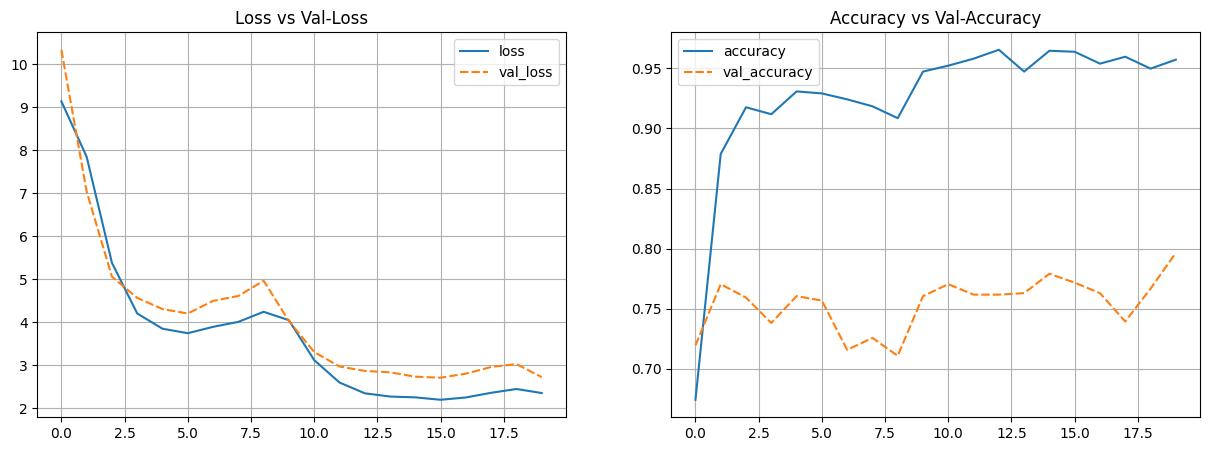

In [71]:
# Plot training results

history_rn_df = pd.DataFrame(history_rn.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_rn_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_rn_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [72]:
# Check the performance of test-set

## Get the probability
y_pred_prob_tl2 = model_rn.predict(test_set_tl2)

## Get class with maximum probability
y_pred_class_tl2 = np.argmax(y_pred_prob_tl2, axis=-1)

## Display Classification Report
print(classification_report(test_set_tl2.classes, y_pred_class_tl2, target_names=np.array(list(train_set_tl2.class_indices.keys()))))

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 540ms/step
              precision    recall  f1-score   support

   cardboard       0.99      0.81      0.89        81
       glass       0.80      0.84      0.82       101
       metal       0.84      0.89      0.86        82
       paper       0.82      0.99      0.90       119
     plastic       0.86      0.78      0.82        97
       trash       1.00      0.57      0.73        28

    accuracy                           0.85       508
   macro avg       0.88      0.82      0.84       508
weighted avg       0.86      0.85      0.85       508



# Model Saving

setelah dilakukan pembuatan model dengan menggunakan 3 model improvement didapatkan model restnet yang paling bagus dibandingkan dengan model lainnya walaupun model cenderung overfit

In [88]:
# Save model in Keras format
model_rn.save('model_rn.keras')



# Kesimpulan

model restnet menjadi model terbaik dibandingkan model lainnya
namun model masih overfit

adapun improvement yang dilakukan berikutnya dengan menggunakan metode smote dan undersampling karna data yang didapat imbalance dan menyebabkan model overfit